In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# 1️⃣ GitHub에서 CSV 데이터 불러오기
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/titanic.csv"
response = requests.get(url)
data = StringIO(response.text)

# 2️⃣ 데이터 로드 및 확인
df = pd.read_csv(data)

display(df)  # 데이터 일부 출력
print(df.columns)  # 컬럼명 확인


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [2]:
#결측치 확인
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [3]:
#Cabin 컬럼은 삭제 (drop 사용)
#결측치가 687개(많음) -> 전체 데이터셋의 절반 이상이 비어 있음 → 삭제하는 게 나음.
df.drop(columns=["Cabin"], inplace=True)  # Cabin 컬럼 삭제

#Embarked 컬럼은 결측치 있는 행만 삭제 (dropna(subset=[]) 사용)
#결측치가 2개(적음) -> 결측치 있는 행만 삭제해도 데이터 손실이 거의 없음.
df.dropna(subset=["Embarked"], inplace=True)  # Embarked 결측치가 있는 행 삭제

#Age 컬럼은 평균값으로 채우기 (fillna(df["Age"].mean()) 사용)
#결측치가 177개(많지만 전체 데이터에 비해 적당함) -> 행을 삭제하면 손실이 크므로, 평균값으로 채우는 게 좋음.
#df["Age"].fillna(df["Age"].mean(), inplace=True)  # Age의 결측치는 평균값으로 대체
df["Age"] = df["Age"].fillna(df["Age"].mean()) 
# 결측치가 제대로 처리됐는지 확인
print(df.isnull().sum())  # 모든 결측치가 사라졌는지 확인


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [4]:
# Survived 컬럼(레이블)의 각 클래스 분포 확인
survived_counts = df['Survived'].value_counts()
print(survived_counts)

Survived
0    549
1    340
Name: count, dtype: int64


In [5]:
# Survived 예측에 필요 없는 컬럼 제거
df.drop(columns=["PassengerId", "Name", "Ticket", "Fare", "Embarked"], inplace=True)

# 컬럼 삭제 후 데이터 확인
display(df)  # 변경된 데이터셋 확인
print(df['Sex'].value_counts()) # Sex 컬럼 분포 확인

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.000000,1,0
1,1,1,female,38.000000,1,0
2,1,3,female,26.000000,0,0
3,1,1,female,35.000000,1,0
4,0,3,male,35.000000,0,0
...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0
887,1,1,female,19.000000,0,0
888,0,3,female,29.642093,1,2
889,1,1,male,26.000000,0,0


Sex
male      577
female    312
Name: count, dtype: int64


In [6]:
# 데이터 로드 (이전 전처리된 데이터 사용)
# LabelEncoder 객체 생성
encoder = LabelEncoder()
# 'Sex' 컬럼을 숫자로 변환 (male=1, female=0 자동 할당됨)
#  map()으로도 가능. -> 직접 숫자 할당 가능.
df['Sex'] = encoder.fit_transform(df['Sex'])
print(df['Sex'].value_counts())
display(df)

Sex
1    577
0    312
Name: count, dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.000000,1,0
1,1,1,0,38.000000,1,0
2,1,3,0,26.000000,0,0
3,1,1,0,35.000000,1,0
4,0,3,1,35.000000,0,0
...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0
887,1,1,0,19.000000,0,0
888,0,3,0,29.642093,1,2
889,1,1,1,26.000000,0,0


In [7]:
# 2️⃣ 레이블(y)과 특징(X) 설정
X = df.drop(columns=["Survived"])  # 특징 데이터 (Survived 제외)
y = df["Survived"]  # 레이블 (생존 여부)

# 3️⃣ 훈련 데이터와 테스트 데이터로 분할 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Confusion Matrix 시각화 함수
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

Matplotlib is building the font cache; this may take a moment.


Decision Tree Accuracy: 0.8146
DT Confusion Matrix:
 [[94 15]
 [18 51]]


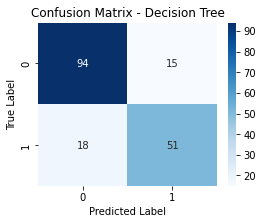

In [10]:
# 🎯 (1) Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)  # 학습
y_pred_dt = dt_model.predict(X_test)  # 예측
dt_acc = accuracy_score(y_test, y_pred_dt)  # 정확도 계산
print(f"Decision Tree Accuracy: {dt_acc:.4f}")
print("DT Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")

Random Forest Accuracy: 0.8146
RF Confusion Matrix:
 [[93 16]
 [17 52]]


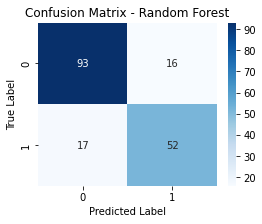

In [11]:
# 🎯 (2) Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print("RF Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

SVM Accuracy: 0.6404
SVM Confusion Matrix:
 [[107   2]
 [ 62   7]]


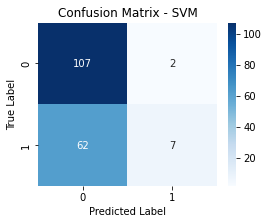

In [12]:
# 🎯 (3) SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc:.4f}")
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

Logistic Regression Accuracy: 0.7921
LR Confusion Matrix:
 [[88 21]
 [16 53]]


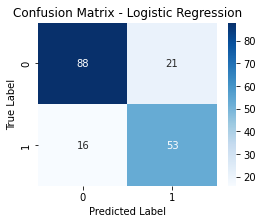

In [13]:
# 🎯 (4) Logistic Regression
lr_model = LogisticRegression(max_iter=10000)  # 반복 횟수 증가
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print("LR Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

KNN Accuracy: 0.7528
KNN Confusion Matrix:
 [[86 23]
 [21 48]]


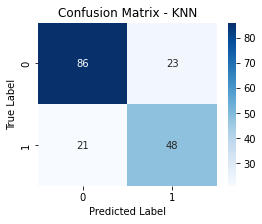

In [14]:
# 🎯 (5) KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
plot_confusion_matrix(y_test, y_pred_knn, "KNN")

#  Confusion Matrix 읽는 법.
Predicted Label과 True Label 값이 일치하면 정답 아닌 것은 틀린 것.